In [ ]:
import pandas as pd
import numpy as np
import os
import re
import datetime
from datetime import date
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from IPython.display import display

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM,Dropout,GRU,Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from statsmodels.tsa.seasonal import STL


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

plt.style.use('seaborn')
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2024-01-02 09:16:25--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 173.194.195.101, 173.194.195.102, 173.194.195.139, ...
Connecting to drive.google.com (drive.google.com)|173.194.195.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ivk9ib59692r87qcmd958lc0cic009b9/1704186975000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=3c9f9dbc-2565-4972-bec3-c191db8ce7b1 [following]
--2024-01-02 09:16:25--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ivk9ib59692r87qcmd958lc0cic009b9/1704186975000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=3c9f9dbc-2565-4972-bec3-c191db8ce7b1
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 172.217.214.132, 2607:f8b0:4001:c05::84
Connecting to d

<ipython-input-28-264e64ccd50a>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Preparing Data

In [ ]:
concat_df = pd.read_csv("/content/drive/MyDrive/文字探勘/final/main_data.csv")

In [ ]:
concat_df

,Unnamed: 0,id,time,commodity_id,category,ProductName,total_quantity,price,total_amount,new_Category,SubCategory
0,0,4043721,2021-12-31 16,5828350,['女生衣著'],三角造型扣羽絨棉背心特價不退,4,498,1992,女生衣著,背心外套
1,1,4044252,2021-12-31 16,5814868,['女生衣著'],妞第002標80189黑色牛仔褲可小一碼帶,2,330,660,女生衣著,牛仔褲
2,2,4044314,2021-12-31 16,5819833,['女生衣著'],妞第039標小可愛,1,199,199,女生衣著,細肩帶/繞頸背心
3,3,4043520,2021-12-31 16,5828286,['女生衣著'],螢光色羽絨棉背心特價不退,5,399,1995,女生衣著,背心外套
4,4,4044508,2021-12-31 17,5828576,['女生衣著'],第113標黑絨套裝1,1,190,190,女生衣著,個人套裝
...,...,...,...,...,...,...,...,...,...,...,...
719441,719441,21439908,2022-12-31 15,10674680,['男生衣著'],76Nike06511左胸三勾勾大學踢12341,4,1234,4936,男生衣著,大學T
719442,719442,21440617,2022-12-31 15,10673729,['男生衣著'],85Tommy側邊國旗縮口棉褲9991,3,999,2997,男生衣著,長褲
719443,719443,21439635,2022-12-31 15,10673152,['男生衣著'],69Nike25248左胸電繡勾勾外套13891,3,1389,4167,女生衣著,夾克
719444,719444,21440383,2022-12-31 15,10623044,['女生衣著'],509壓折綠豹紋裙,1,480,480,女生衣著,裙裝


In [ ]:
print(f"Number of sub category in dataset : {concat_df['SubCategory'].nunique()}")

Number of sub category in dataset : 39


In [ ]:
def prepareDf(df,gender):
    df['time'] = pd.to_datetime(df['time'])
    df['time'] = df['time'].dt.date
    df.loc[df['time'] == date(2021, 12, 31), 'time'] = date(2022, 1, 1)

    df = df[df["new_Category"] == gender]
    # aggregate
    result_df = df.groupby(['time','SubCategory'])["total_quantity"].sum().reset_index()

    return result_df


In [ ]:
def paddingDate(df):
    df['time'] = pd.to_datetime(df['time'])
    if len(df) != 365:
        complete_date = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
        complete_df = pd.DataFrame({'time': complete_date})
        merged = pd.merge(complete_df, df, on='time', how='left')
        merged['total_quantity'].fillna(0, inplace=True)

        return merged
    else:
        return df

In [ ]:
df_man = prepareDf(concat_df,"男生衣著")
df_women = prepareDf(concat_df,"女生衣著")

In [ ]:
df_man

,time,SubCategory,total_quantity
0,2022-01-01,Polo衫,11
1,2022-01-01,T恤,388
2,2022-01-01,內衣褲,497
3,2022-01-01,冬季外套/大衣,14
4,2022-01-01,外套,103
...,...,...,...
6142,2022-12-31,背心,320
6143,2022-12-31,衛生衣,32
6144,2022-12-31,襪子,43
6145,2022-12-31,襯衫,32


In [ ]:
df_women

,time,SubCategory,total_quantity
0,2022-01-01,T恤,275
1,2022-01-01,個人套裝,70
2,2022-01-01,內衣,46
3,2022-01-01,內褲,314
4,2022-01-01,冬季外套/大衣,64
...,...,...,...
9649,2022-12-31,襪子,32
9650,2022-12-31,襯衫,260
9651,2022-12-31,西裝,12
9652,2022-12-31,連身長褲,29


In [ ]:
df_women_pants = df_women[df_women["SubCategory"] == "長褲"]

In [ ]:
df_women_pants

,time,SubCategory,total_quantity
18,2022-01-01,長褲,21
41,2022-01-02,長褲,256
65,2022-01-03,長褲,20
90,2022-01-04,長褲,101
115,2022-01-05,長褲,234
...,...,...,...
9540,2022-12-27,長褲,1510
9569,2022-12-28,長褲,1735
9597,2022-12-29,長褲,1833
9625,2022-12-30,長褲,378


In [ ]:
print(f"Before : {len(df_women_pants)}")
df_women_pants = paddingDate(df_women_pants)
print(f"After : {len(df_women_pants)}")

Before : 362
After : 365


<ipython-input-7-4ae6dd4be2f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'])


## Temperature

In [ ]:
temperature_2022 = pd.read_csv("/content/drive/MyDrive/文字探勘/final/Temperature/2022Temperature.csv")
temperature_2023 = pd.read_csv("/content/drive/MyDrive/文字探勘/final/Temperature/2023Temperature.csv")

In [ ]:
temperature_2022['Date'] = pd.to_datetime(temperature_2022['Date'], format='%Y/%m/%d').dt.strftime('%Y-%m-%d')
temperature_2023['Date'] = pd.to_datetime(temperature_2023['Date'], format='%Y/%m/%d').dt.strftime('%Y-%m-%d')

# Make dataframe list for every sub-category

In [ ]:
# make every sub-category as a data frame
def DFdict(gender,sublist):
    dfDict = {}
    for subcat in sublist:
        tmp = gender[gender["SubCategory"] == subcat]
        # padding & transform to time format
        tmp = paddingDate(tmp)

        # season decompose
        season_df = tmp[['time', 'total_quantity']].copy()
        season_df.set_index('time', inplace=True)
        stl_result = STL(season_df,seasonal = 31).fit()
        trend, seasonal, residual = stl_result.trend, stl_result.seasonal, stl_result.resid
        tmp["trend"] = trend.to_list()
        tmp["residual"] = residual.to_list()
        tmp = tmp[['time','total_quantity', 'trend', 'residual']]
        tmp.set_index('time',inplace = True)

        # shift
        tmp["shift"] = tmp["total_quantity"].shift(1)
        tmp.iloc[0,3]= 0

        # temperature
        tmp['AvgTemp'] = [a for a in temperature_2022['Avg']]

        dfDict[subcat] = tmp

    return dfDict

In [ ]:
sublist_women = df_women['SubCategory'].unique()
sublist_man = df_man['SubCategory'].unique()

In [ ]:
df_man_Dict = DFdict(df_man,sublist_man)

<ipython-input-7-4ae6dd4be2f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'])
<ipython-input-7-4ae6dd4be2f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'])
<ipython-input-7-4ae6dd4be2f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [ ]:
df_women_Dict = DFdict(df_women,sublist_women)

<ipython-input-7-4ae6dd4be2f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'])
<ipython-input-7-4ae6dd4be2f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'])
<ipython-input-7-4ae6dd4be2f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [ ]:
df_women_Dict["長褲"]

,total_quantity,trend,residual,shift,AvgTemp
time,,,,,
2022-01-01,21.0,120.748852,-6.538321,0.0,19.0
2022-01-02,256.0,118.724901,181.183002,21.0,17.0
2022-01-03,20.0,118.431362,-81.077502,256.0,20.0
2022-01-04,101.0,119.030136,-200.461127,20.0,18.5
2022-01-05,234.0,119.531752,95.326314,101.0,20.0
...,...,...,...,...,...
2022-12-27,1510.0,1105.575728,349.331902,593.0,16.5
2022-12-28,1735.0,1062.973003,138.457841,1510.0,17.0
2022-12-29,1833.0,1018.899985,389.084079,1735.0,16.5


In [ ]:
df_man_Dict["長褲"]

,total_quantity,trend,residual,shift,AvgTemp
time,,,,,
2022-01-01,376.0,232.752581,127.390824,0.0,19.0
2022-01-02,68.0,212.354402,-128.775674,376.0,17.0
2022-01-03,129.0,192.796971,-22.889158,68.0,20.0
2022-01-04,287.0,174.138106,93.941892,129.0,18.5
2022-01-05,76.0,156.862996,-67.543375,287.0,20.0
...,...,...,...,...,...
2022-12-27,1359.0,843.833044,519.598121,658.0,16.5
2022-12-28,1247.0,831.389428,-99.018152,1359.0,17.0
2022-12-29,897.0,816.267063,-62.036447,1247.0,16.5


# Model

In [ ]:
def toXY(df,num_lookback, num_forecast):
    df_as_np = df.to_numpy()
    # scale the features
    global scale_np # the initail scaled data
    scale_np = scaler.fit_transform(df_as_np.reshape(-1,len(df_as_np[0])))
    scaler_y.fit_transform(df['total_quantity'].to_numpy().reshape(-1,1))

    X = []
    y = []
    for i in range(num_lookback, len(scale_np) - num_forecast + 1):
        row = [a for a in scale_np[i - num_lookback : i]]
        X.append(row)
        label = scale_np[i : i + num_forecast][0][0]
        y.append(label)
    return np.array(X), np.array(y)

In [ ]:
def single_predict(x_past,model):
    Y_ = model.predict(x_past).reshape(-1, 1)
    Y_ = Y_.flatten()
    return Y_.reshape(1, -1)

In [ ]:
# generate the forecasts
def future_N(df,n,lookback,model):
    tmp_window = scale_np.copy() # intial sliding window
    start_date = pd.to_datetime('2023-01-01')
    date_ranges = pd.date_range(start=start_date, periods = n, freq = 'D')
    future_times = []
    future_predicts = []
    shift_value = 0
    for i in range(n):
        X_ = tmp_window[-lookback:]  # last available input sequence
        X_ = X_.reshape(1,lookback,len(tmp_window[0]))
        new_predict = single_predict(X_,model)
        tmp_predict = new_predict[0][0] if new_predict[0][0] >=0 else np.float32(0)
        new_X = [tmp_predict,tmp_window[i][1],tmp_window[i][2],shift_value,tmp_window[i][4]]
        shift_value = new_predict[0][0]
        # print(new_X)
        tmp_window = np.vstack((tmp_window, new_X))# insert newest predict as new day
        # store the result to data frame
        future_times.append(date_ranges[i].date())
        future_predicts.append(scaler_y.inverse_transform(tmp_predict.reshape(1,-1))[0][0])
    future_df = pd.DataFrame({
        'time':future_times,
        'Actual':np.nan,
        'Test_Predicted':np.nan,
        'Predicted':future_predicts
    })

    result_df = pd.concat([df, future_df], ignore_index=True)

    return result_df

## Bundle the process into function

In [ ]:
def modeling(df,lookback,forecast):
    # init
    LOOKBACK = lookback
    FORECAST = forecast

    # prepare training data
    X, y = toXY(df,LOOKBACK,FORECAST)
    X_train, y_train = X[:304], y[:304]
    X_valid, y_valid = X[304:], y[304:]

    # construct model
    model_gru = Sequential()
    model_gru.add(GRU(128, return_sequences=True, input_shape=(LOOKBACK, 5), name='gru_1'))
    model_gru.add(Dropout(0.3))  # Add dropout for regularization
    model_gru.add(GRU(128, name='gru_2'))
    model_gru.add(Dense(64))
    model_gru.add(Dropout(0.3))  # Add dropout for regularization
    model_gru.add(Dense(16))
    # model_gru.add(Dropout(0.2))  # Add dropout for regularization
    model_gru.add(Dense(1))
    model_gru.compile(loss='mean_squared_error', optimizer=optimizers.Adam(learning_rate=0.01), metrics=['mean_absolute_error'])

    # callback function
    es = EarlyStopping(monitor='val_mean_absolute_error', min_delta=0, patience=15, verbose=1, mode='auto')
    callbacks = [es]

    MODEL = model_gru

    # Start training model
    fit = MODEL.fit(
        X_train, y_train,
        batch_size=32,
        epochs=1000,
        verbose=1,
        validation_data=(X_valid, y_valid),
        callbacks=callbacks)

    # generate the model predictions
    y_pred = MODEL.predict(X_valid)
    y_pred = scaler_y.inverse_transform(y_pred)
    y_pred = y_pred.flatten()

    # store and format the model predictions
    test_df = df.copy()
    test_df.rename(columns={'total_quantity': 'Actual'}, inplace=True)
    axis_x = test_df.index.strftime('%Y-%m-%d').to_list()
    test_df['time'] = axis_x
    test_df['Test_Predicted'] = np.nan
    test_df['Test_Predicted'].iloc[- y_pred.shape[0]:] = y_pred

    # start generating future prediction
    result_df = future_N(test_df,365,LOOKBACK,MODEL)

    return result_df


# Analysis

In [ ]:
import matplotlib.cm as cm
import matplotlib.dates as mdates

### 1. All sub-category predict

In [ ]:
# define scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

Epoch 1/1000
10/10 [==============================] - 5s 84ms/step - loss: 0.8463 - mean_absolute_error: 0.5243 - val_loss: 0.0059 - val_mean_absolute_error: 0.0668
Epoch 2/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0295 - mean_absolute_error: 0.1310 - val_loss: 0.0013 - val_mean_absolute_error: 0.0307
Epoch 3/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0249 - mean_absolute_error: 0.1114 - val_loss: 0.0017 - val_mean_absolute_error: 0.0293
Epoch 4/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0188 - mean_absolute_error: 0.0959 - val_loss: 0.0030 - val_mean_absolute_error: 0.0433
Epoch 5/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.0170 - mean_absolute_error: 0.0823 - val_loss: 0.0017 - val_mean_absolute_error: 0.0365
Epoch 6/1000
10/10 [==============================] - 0s 10ms/step - loss: 0.0132 - mean_absolute_error: 0.0687 - val_loss: 0.0023 - val_mean_absolute_error: 0.0420
Epoch 7/10

<ipython-input-25-8b5d23c3495c>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Test_Predicted'].iloc[- y_pred.shape[0]:] = y_pred


1/1 [==============================] - 0s 21ms/step


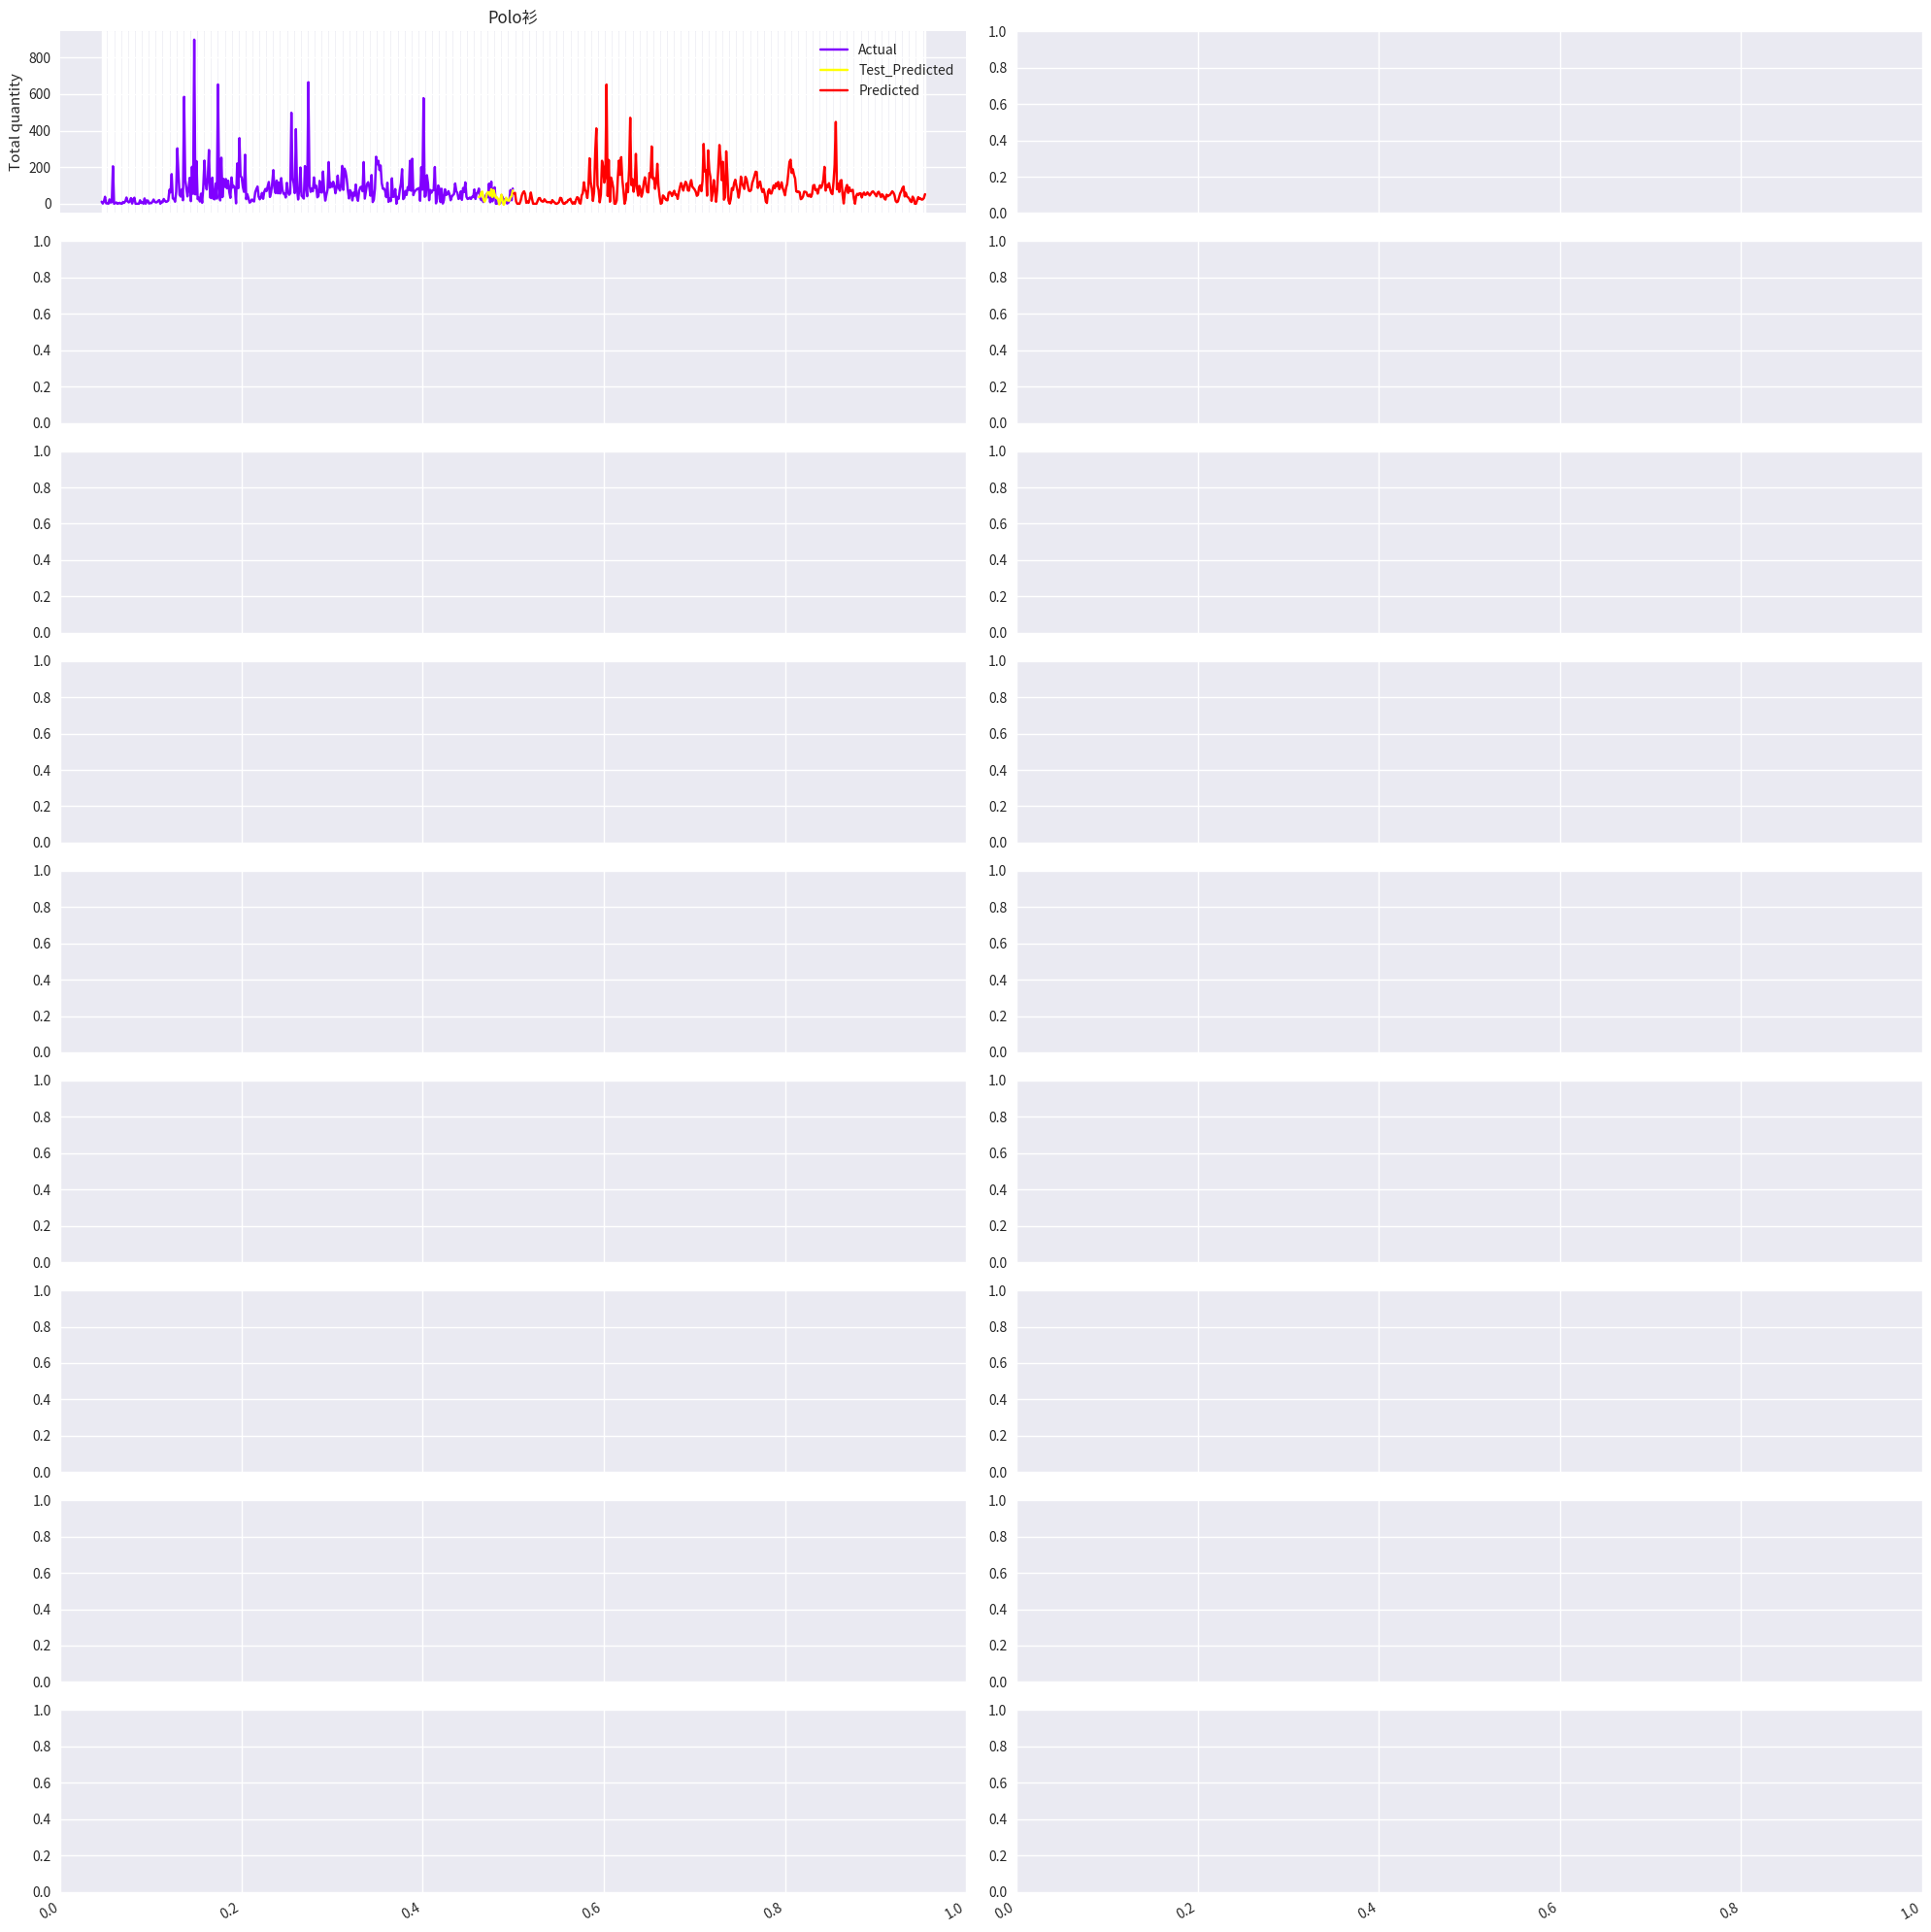

In [ ]:
# plotting
colors = cm.rainbow(np.linspace(0, 1, len(sublist_man)))
n = len(sublist_man)
ncols = 2
nrows = n // ncols if n % ncols == 0 else n // ncols + 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
axs = axs.ravel()  # 將子圖平坦化以便於迭代

# man
for idx, (color, subcat) in enumerate(zip(colors, sublist_man)):
  if idx > 0:
    break
  tmp_man_df = modeling(df_man_Dict[f"{subcat}"],30,1)
  tmp_man_df['time'] = pd.to_datetime(tmp_man_df['time'])

  # Plot each subcategory on a separate subplot
  axs[idx].plot(tmp_man_df['time'].astype(str), tmp_man_df['Actual'], color=color, label='Actual')
  axs[idx].plot(tmp_man_df['time'].astype(str), tmp_man_df['Test_Predicted'], color="yellow", label='Test_Predicted')
  axs[idx].plot(tmp_man_df['time'].astype(str), tmp_man_df['Predicted'], color="red", label='Predicted')

  axs.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
  axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

  axs[idx].set_title(subcat)
  axs[idx].set_xlabel('Date')
  axs[idx].set_ylabel('Total quantity')
  axs[idx].legend()

# Improve layout
plt.tight_layout()
# Display the subplots
plt.show()

In [ ]:
t_df = modeling(df_man_Dict["長褲"],30,1)

Epoch 1/1000
10/10 [==============================] - 5s 113ms/step - loss: 0.5098 - mean_absolute_error: 0.4469 - val_loss: 0.0352 - val_mean_absolute_error: 0.1500
Epoch 2/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0256 - mean_absolute_error: 0.1274 - val_loss: 0.0382 - val_mean_absolute_error: 0.1535
Epoch 3/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0165 - mean_absolute_error: 0.0981 - val_loss: 0.0327 - val_mean_absolute_error: 0.1439
Epoch 4/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0159 - mean_absolute_error: 0.0969 - val_loss: 0.0376 - val_mean_absolute_error: 0.1512
Epoch 5/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0128 - mean_absolute_error: 0.0858 - val_loss: 0.0403 - val_mean_absolute_error: 0.1554
Epoch 6/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0116 - mean_absolute_error: 0.0797 - val_loss: 0.0314 - val_mean_absolute_error: 0.1405
Epoch 7/1

<ipython-input-37-8b5d23c3495c>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Test_Predicted'].iloc[- y_pred.shape[0]:] = y_pred


[0.060146958, 0.18377134634657907, 0.2493899968711556, 0.15761079, 0.4222222222222223]
1/1 [==============================] - 0s 20ms/step
[0.0, 0.1635583355101421, 0.30635062790845674, 0.060146958, 0.3555555555555556]
1/1 [==============================] - 0s 18ms/step
[0.0, 0.14484433728810214, 0.22761896609438817, -0.012208654, 0.4222222222222223]
1/1 [==============================] - 0s 19ms/step
[0.0, 0.1282235548823485, 0.24563372319359092, -0.026380612, 0.24444444444444446]
1/1 [==============================] - 0s 18ms/step
[0.017500324, 0.11734695720051926, 0.2323337761707591, -0.0038720015, 0.2666666666666667]
1/1 [==============================] - 0s 19ms/step
[0.07281731, 0.11765032162051654, 0.2683818783901954, 0.017500324, 0.2666666666666667]
1/1 [==============================] - 0s 20ms/step
[0.1396795, 0.12108853096387996, 0.22805962532546326, 0.07281731, 0.3555555555555556]
1/1 [==============================] - 0s 19ms/step
[0.13718542, 0.13064677143489245, 0.273982

,Actual,trend,residual,shift,AvgTemp,time,Test_Predicted,Predicted
0,376.0,232.752581,127.390824,0.0,19.0,2022-01-01,NaN,NaN
1,68.0,212.354402,-128.775674,376.0,17.0,2022-01-02,NaN,NaN
2,129.0,192.796971,-22.889158,68.0,20.0,2022-01-03,NaN,NaN
3,287.0,174.138106,93.941892,129.0,18.5,2022-01-04,NaN,NaN
4,76.0,156.862996,-67.543375,287.0,20.0,2022-01-05,NaN,NaN
...,...,...,...,...,...,...,...,...
725,NaN,NaN,NaN,NaN,NaN,2023-12-27,NaN,1613.849365
726,NaN,NaN,NaN,NaN,NaN,2023-12-28,NaN,620.470764
727,NaN,NaN,NaN,NaN,NaN,2023-12-29,NaN,473.951874
728,NaN,NaN,NaN,NaN,NaN,2023-12-30,NaN,742.855408


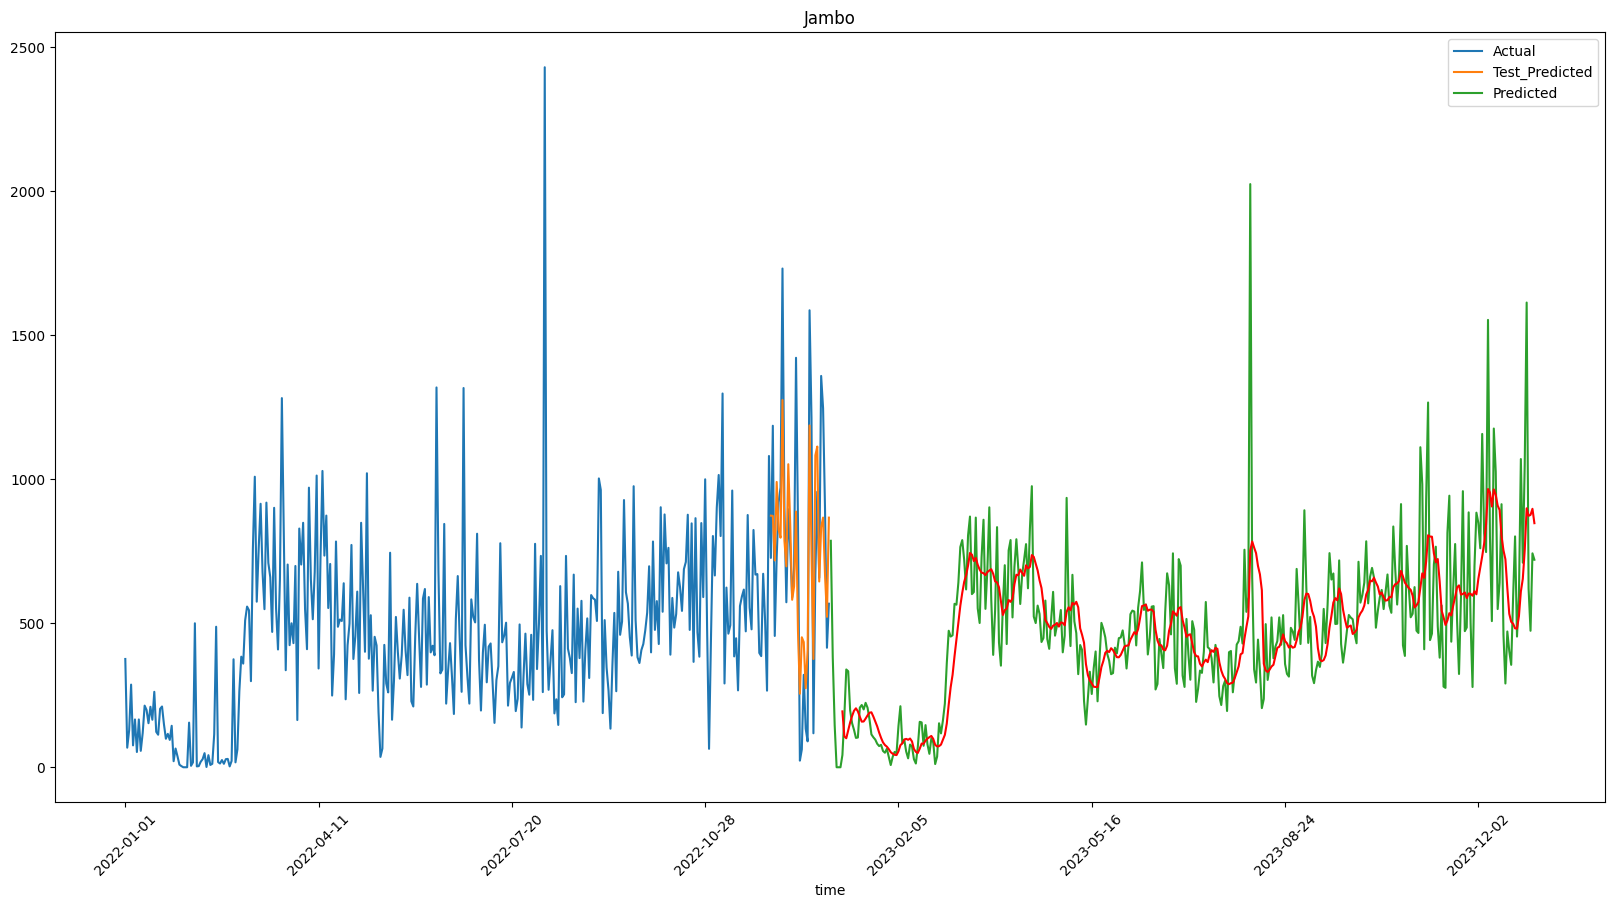

In [ ]:
t_df.plot(x='time', y=['Actual','Test_Predicted', 'Predicted'], title='Jambo',figsize=(20, 10))
display(t_df)
# # Set 'time' as the index
# tt_df = t_df.copy()
# tt_df['time'] = tt_df['time'].astype(str)
# tt_df.set_index('time', inplace=True)

# Calculate the 7-day rolling average
# rolling_avg = tt_df['Predicted'].rolling(window=7).mean()
# plt.plot(rolling_avg.index, rolling_avg, label='7-Day Rolling Average', color='red')
# plt.xticks(rotation = 45)

plt.show()